In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from cleaning_data import clean
from get_macrodata import monthly_data, daily_data

Текущая рабочая директория: c:\Users\vasil\YandexDisk\project\LK_and_commets 
Оттуда буду брать данные, там должна быть папка data, а в ней данные по годам


c:\Users\vasil\AppData\Local\Programs\Python\Python313\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [2]:
var_spec = clean(monthly_data.loc[monthly_data.index > dt(2014, 6, 1), ['PMI_manufacturing', 'ru_cpi', 'real_rate', 'pi_e', 'real_brent']])

Это pandas DataFrame!


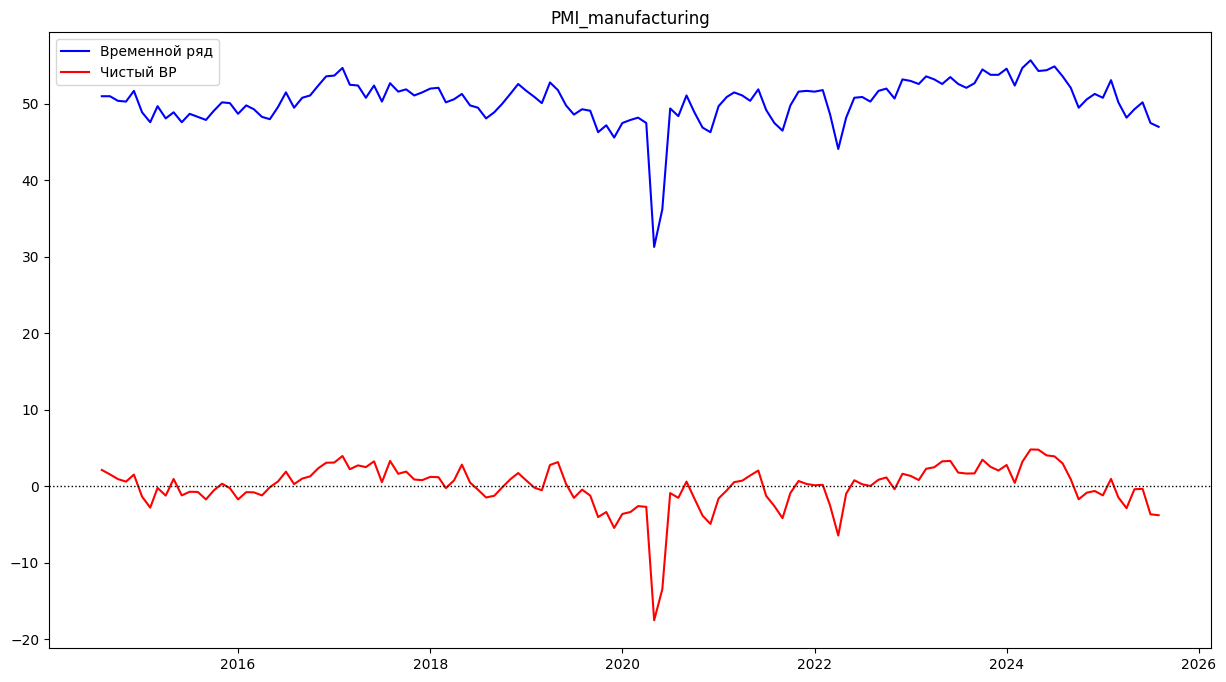

Исходный ряд PMI_manufacturing оказался стационарным


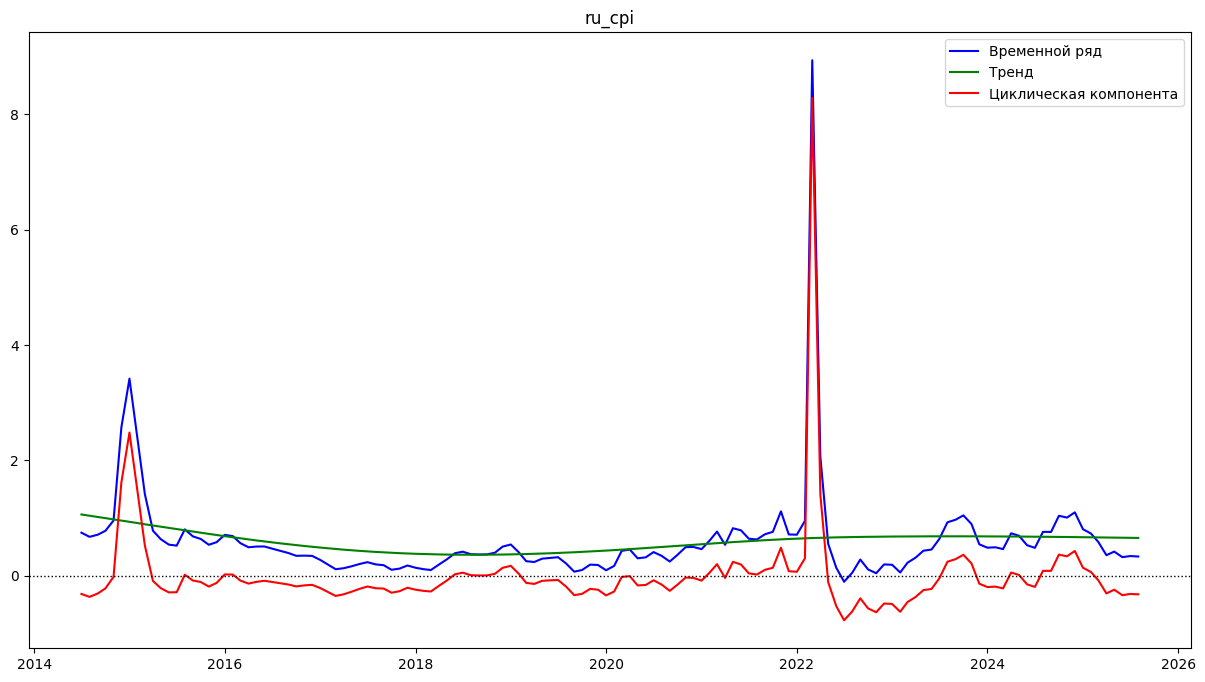

Исходный ряд ru_cpi оказался стационарным


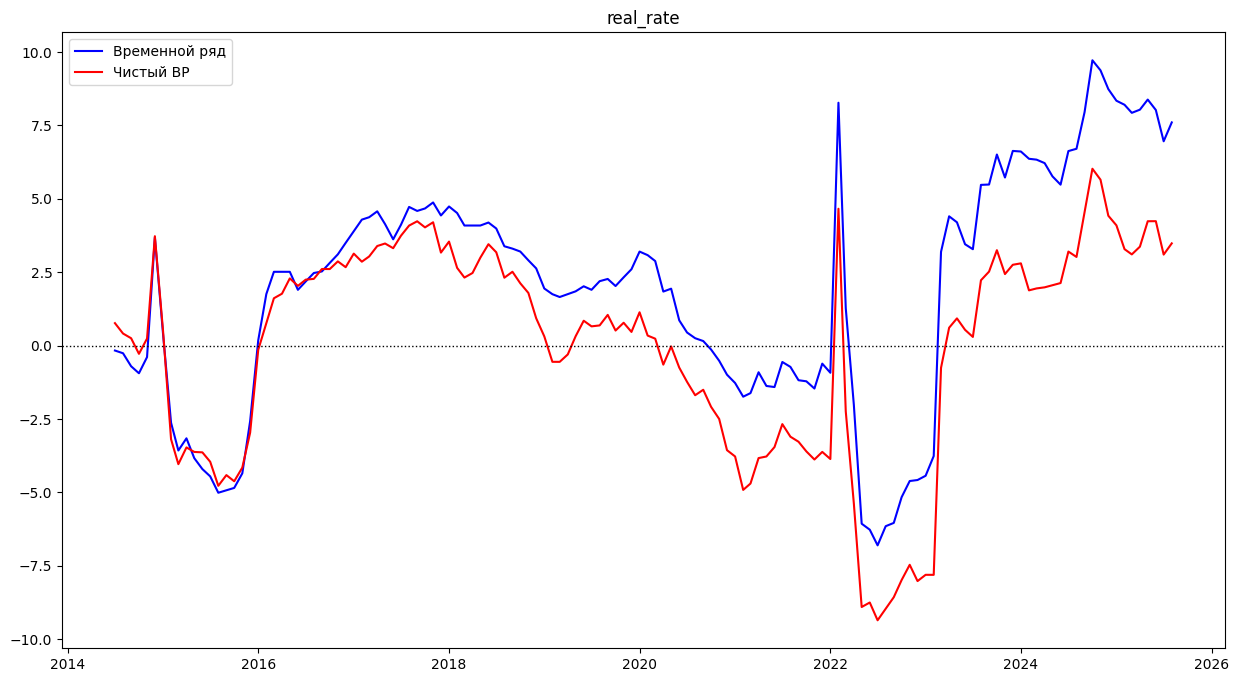

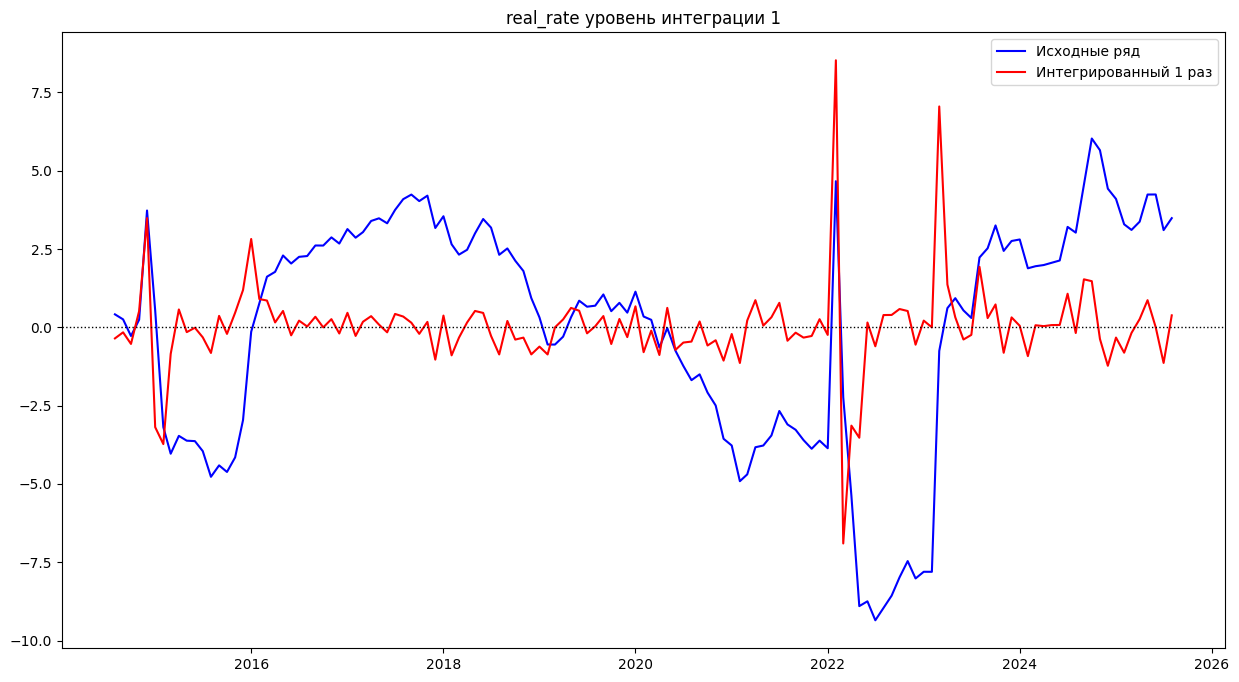

Обрати внимание, что для переменной var_name есть пробел в данных
между 73 и 68 наблюдениями длинной больше 2


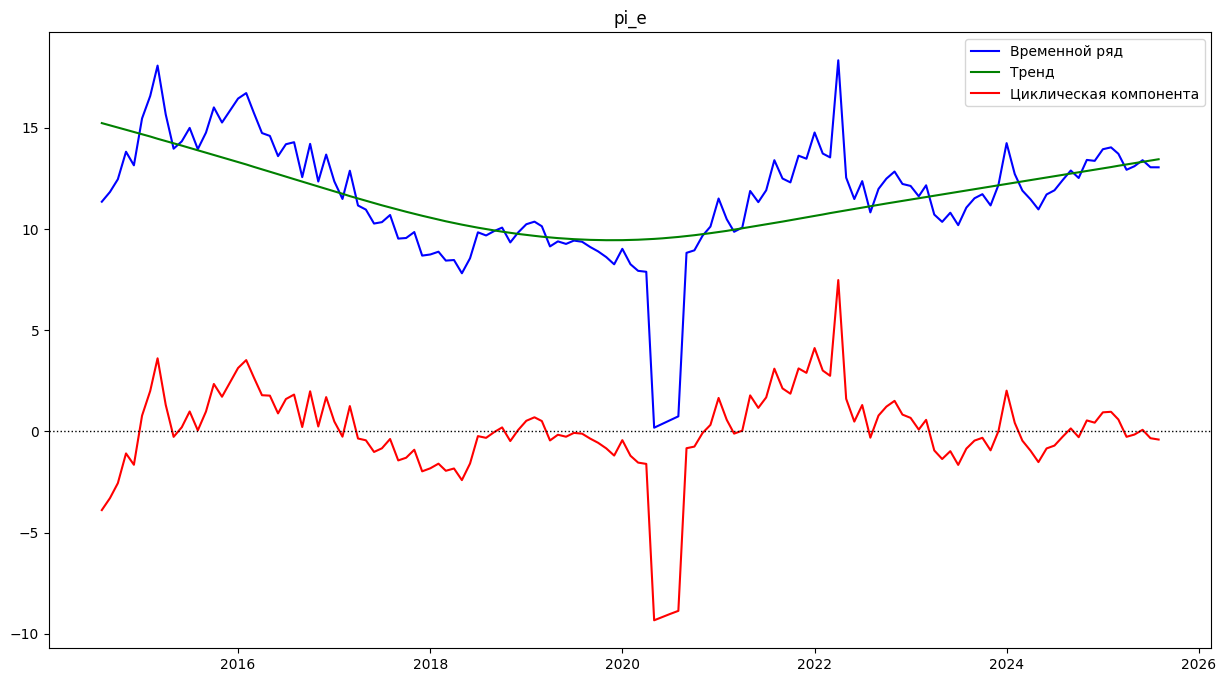

Исходный ряд pi_e оказался стационарным


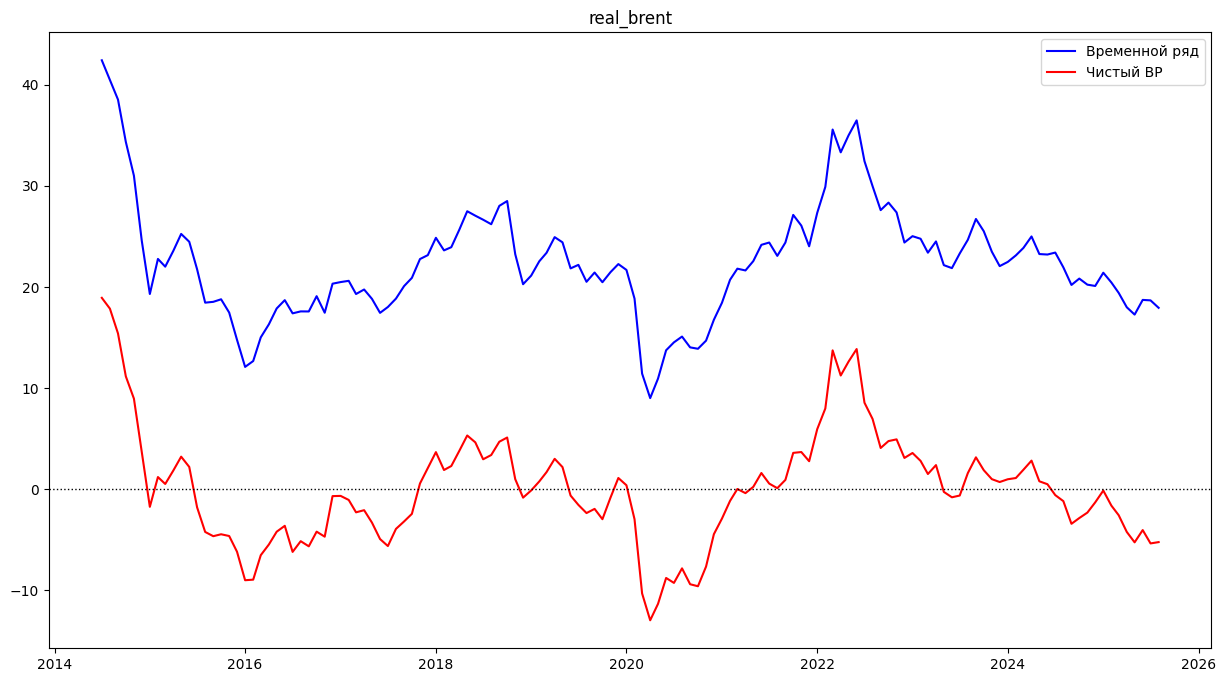

Исходный ряд real_brent оказался стационарным


In [3]:
df, data = var_spec.LOS(use_harmonics=False, only_KPSS = False, hp_filter_map={'log_credits_hh':True,
                                                                               'ru_cpi': True,
                                                                               'real_rate': False,
                                                                               'pi_e': True})

In [35]:
covid_start, duration_covid = (data.T.index < dt(2020, 3, 1)).sum(), 5
svo_start, svo_duration = (data.T.index < dt(2022, 2, 1)).sum(), 2

data = data.T.sort_index(ascending=False).T.copy(deep=True)
data.loc['covid', :] = np.concatenate([np.zeros(data.shape[1]-covid_start-duration_covid), np.ones(duration_covid), np.zeros(covid_start)])
#data.loc['svo', :] = np.concatenate([np.zeros(svo_start), np.ones(svo_duration), np.zeros(data.shape[1]-svo_start-svo_duration)])
data = data.copy(deep = True)
data.loc['real_rate', :] = monthly_data.sort_index(ascending=False)['real_rate'].iloc[1:132]

In [36]:
data

,2025-07-01,2025-06-01,2025-05-01,2025-04-01,2025-03-01,2025-02-01,2025-01-01,2024-12-01,2024-11-01,2024-10-01,...,2015-05-01,2015-04-01,2015-03-01,2015-02-01,2015-01-01,2014-12-01,2014-11-01,2014-10-01,2014-09-01,2014-08-01
PMI_manufacturing,-3.774797,-3.652846,-0.325573,-0.380118,-2.852846,-1.452846,0.974427,-1.180118,-0.607391,-0.825573,...,-1.183518,0.961936,-1.210791,-0.210791,-2.783518,-1.338064,1.534664,0.616482,0.952846,1.561936
ru_cpi,-0.316267,-0.336867,-0.242479,-0.306467,-0.079319,0.063876,0.139209,0.429199,0.336873,0.366330,...,-0.215638,-0.090351,0.523149,1.455597,2.482129,1.616019,-0.019367,-0.219180,-0.308984,-0.366243
real_rate,6.961703,8.027256,8.382698,8.038564,7.930858,8.205442,8.343258,8.738960,9.378131,9.720756,...,-3.831057,-3.155264,-3.569484,-2.625224,0.430189,3.686166,-0.388443,-0.939397,-0.700984,NaN
pi_e,-0.398470,-0.332360,0.082253,-0.151525,-0.262888,0.590969,0.972656,0.945276,0.435225,0.545692,...,0.208748,-0.265468,1.313795,3.614417,2.001910,0.781979,-1.644737,-1.083972,-2.552239,-3.291119
real_brent,-5.360678,-4.041552,-5.252878,-4.225030,-2.571564,-1.623382,-0.133063,-1.301953,-2.312713,-2.852753,...,3.218217,1.849377,0.518234,1.201854,-1.742689,3.677248,8.956504,11.158913,15.401492,17.854572
covid,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
from typing import Optional, Tuple, Union

def OLS_estimation(
                   Nseries, #numpy array
                   lag: int = 1,
                   from_class : bool = True,
                   lag_exog: int = 1,

                   exog_data: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, int, int]:

    X = Nseries.values
    p = lag
    K, T = X.shape
    # Основные лаги 
    p_ex = lag_exog
    if exog_data is not None:
        X_ex = exog_data.values
    
    # Основные лаги 
    Z = np.hstack(
        [np.concatenate([np.array([1]), X[:, i:i+p].T.flatten()]).reshape(-1, 1) # type: ignore
            for i in range(T - p)]
    )[:, 1:]
    if exog_data is not None:
        Z_ex = np.hstack(
        [X_ex[:, i:i+p_ex].T.flatten().reshape(-1, 1) # type: ignore
            for i in range(T - p_ex)])[:, 1:]
    
    if exog_data is not None:
        if p > p_ex:
            Z = np.vstack([Z, Z_ex[:, :p_ex-p]])
        elif p == p_ex:
            Z = np.vstack([Z, Z_ex])
        else:
            Z = np.vstack([Z[:, :p-p_ex], Z_ex])
    Y = X[:, :Z.shape[1]]

    B_hat = Y @ Z.T @ np.linalg.inv(Z @ Z.T)
    E = Y - B_hat @ Z
    B_hat_endo = B_hat[:, :K*p+1]
    P = np.linalg.cholesky(E@E.T)
    return Z, Y, B_hat, E, X.shape[0], T, B_hat_endo, P # type: ignore
def irf_companion(
        A_mats : np.ndarray,
        B : np.ndarray, 
        horizon : int
                  ):
    """
    A_mats : list of A_i, i=1..p, каждая (n x n)
    B      : impact matrix (n x n)
    horizon: максимальный лаг
    """
    K = A_mats.shape[0]
    lag = int((A_mats.shape[1])/K)

    # Companion matrix
    
    bottom = np.eye(K*(lag-1), K*lag)
    A_comp = np.vstack([A_mats, bottom])

    # Selector
    J = np.hstack([np.eye(K), np.zeros((K, K*(lag-1)))])

    irfs = []
    for h in range(0, horizon):
        Ah = np.linalg.matrix_power(A_comp, h)
        irfs.append(J @ Ah @ J.T @ B)
    return np.array(irfs)
def random_orthogonal(K):
    Q, _ = np.linalg.qr(np.random.normal(size=(K,K)))
    return Q
u_dict = {0: 'шок AS',
          1: 'шок AD',
          2: 'шок ДКП',
          3: 'шок адаптивных ИО',}
y_dict = {0: 'Выпуск',
          1: 'Инфляция',
          2: 'Реальная ставка',
          3: 'ИО',}

In [37]:
K_endo, K_exog, lag, lag_ex = 4, 2, 6, 1

Z, Y, B_hat, E, K, T, B_hat_endo, P = OLS_estimation(data.iloc[:K_endo, :], 
                                                     lag = lag, 
                                                     exog_data= data.iloc[-K_exog:, :], 
                                                     lag_exog=lag_ex)

In [41]:
pluses = [
    [2, 2, 3], [2, 3, 3]
]
minuses = [
    [1], [2]
]
import sys

required = 1000
np.random.seed(10)
A_mats = B_hat_endo[:, 1:]
lag = int((A_mats.shape[1])/K)

# Companion matrix

bottom = np.eye(K*(lag-1), K*lag)
A_comp = np.vstack([A_mats, bottom])

# Selector
J = np.hstack([np.eye(K), np.zeros((K, K*(lag-1)))])

# number of negative and positive sign restrictions
n_minus, n_plus = len(minuses[0]), len(pluses[0])
i = 0
sim = 0
accepted_0 = []
while len(accepted_0) < required:
    Q = random_orthogonal(K)
    B_inv = P@Q
    #irf0 = J @ A_comp @ J.T @ B_inv
    #cond1 = np.sum(irf0[pluses[0], pluses[1]].flatten() > 0) == n_plus and np.sum(irf0[minuses[0], minuses[1]].flatten() < 0) == n_minus
    cond0 = np.sum(B_inv[pluses[0], pluses[1]].flatten() > 0) == n_plus and np.sum(B_inv[minuses[0], minuses[1]].flatten() < 0) == n_minus
    if cond0:
        accepted_0.append(Q)
        i += 1
    sim += 1
    sys.stdout.write(f"\rНайдено матриц: {i}/{required} ({i*100/required:.1f}%), Использовано симуляций: {sim}")
    sys.stdout.flush()


Найдено матриц: 1000/1000 (100.0%), Использовано симуляций: 17046

In [43]:
pluses = [
    [2, 2, 3], [2, 3, 3]
]
minuses = [
    [1], [2]
]
import sys

required = 1000
np.random.seed(10)
A_mats = B_hat_endo[:, 1:]
lag = int((A_mats.shape[1])/K)

# Companion matrix

bottom = np.eye(K*(lag-1), K*lag)
A_comp = np.vstack([A_mats, bottom])

# Selector
J = np.hstack([np.eye(K), np.zeros((K, K*(lag-1)))])

# number of negative and positive sign restrictions
n_minus, n_plus = len(minuses[0]), len(pluses[0])
i = 0
sim = 0
accepted_1 = []
while len(accepted_1) < required:
    Q = random_orthogonal(K)
    B_inv = P@Q
    irf0 = J @ A_comp @ J.T @ B_inv
    cond1 = np.sum(irf0[pluses[0], pluses[1]].flatten() > 0) == n_plus and np.sum(irf0[minuses[0], minuses[1]].flatten() < 0) == n_minus
    cond0 = np.sum(B_inv[pluses[0], pluses[1]].flatten() > 0) == n_plus and np.sum(B_inv[minuses[0], minuses[1]].flatten() < 0) == n_minus
    if cond0 and cond1:
        accepted_1.append(Q)
        i += 1
    sim += 1
    sys.stdout.write(f"\rНайдено матриц: {i}/{required} ({i*100/required:.1f}%), Использовано симуляций: {sim}")
    sys.stdout.flush()


Найдено матриц: 1000/1000 (100.0%), Использовано симуляций: 26737

In [98]:
pluses = [
    [2], [3]
]
minuses = [
    [], []
]
subroatation = True

import sys

required = 1000
np.random.seed(10)
A_mats = B_hat_endo[:, 1:]
lag = int((A_mats.shape[1])/K)

# Companion matrix

bottom = np.eye(K*(lag-1), K*lag)
A_comp = np.vstack([A_mats, bottom])

# Selector
J = np.hstack([np.eye(K), np.zeros((K, K*(lag-1)))])

# number of negative and positive sign restrictions
n_minus, n_plus = len(minuses[0]), len(pluses[0])
i = 0
sim = 0
accepted_2 = []
while len(accepted_2) < required:
    Q = random_orthogonal(K)
    if subroatation:
        Q = np.identity(K)
        Q_k = random_orthogonal(2)
        Q[2:, 2:] = Q_k
    B_inv = P@Q
    irf1 = J @ A_comp @ J.T @ B_inv
    irf2 = J @ np.linalg.matrix_power(A_comp, 2) @ J.T @ B_inv

    
    cond0 = np.sum(B_inv[pluses[0], pluses[1]].flatten() >= 0) == n_plus
    cond1 = np.sum(irf1[pluses[0], pluses[1]].flatten() >= 0) == n_plus and np.sum(irf1[minuses[0], minuses[1]].flatten() <= 0) == n_minus
    cond2 = np.sum(irf2[pluses[0], pluses[1]].flatten() >= 0) == n_plus and np.sum(irf2[minuses[0], minuses[1]].flatten() <= 0) == n_minus

    if cond1 and cond0:
        accepted_2.append(Q)
        i += 1
    sim += 1
    sys.stdout.write(f"\rНайдено матриц: {i}/{required} ({i*100/required:.1f}%), Использовано симуляций: {sim}")
    sys.stdout.flush()

Найдено матриц: 1000/1000 (100.0%), Использовано симуляций: 1985

In [114]:
accepted = [accepted_0, accepted_1, accepted_2]
horizon = 24
IRF = []
for Q in accepted[2]:
    IRF.append(irf_companion(B_hat_endo[:, 1:], P@Q, horizon))
    

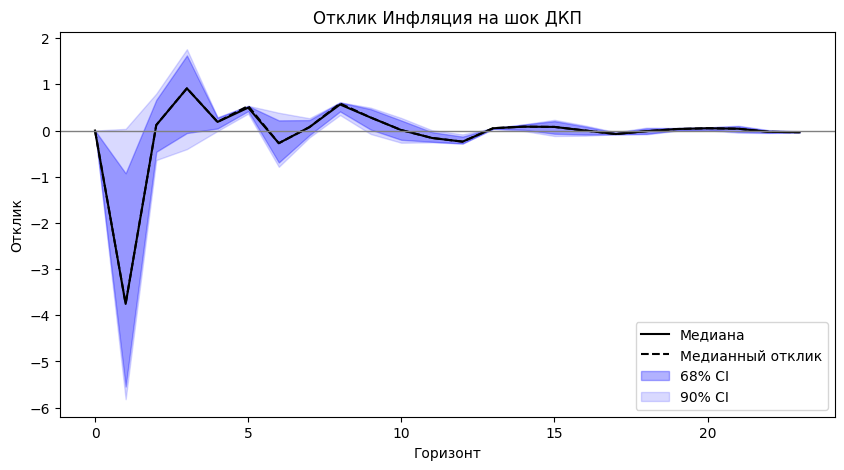

In [116]:
irf = IRF[0]
response = [1, 2]
virf = irf[:, response[0], response[1]]
for irf in IRF[1:]:
    virf = np.vstack([virf, irf[:, response[0], response[1]]])
median_index = pd.DataFrame((virf - np.median(virf, axis = 0))**2).sum(1).sort_values().index[0]
import matplotlib.pyplot as plt

# Имитация матрицы: 10000 симуляций × 20 шагов
np.random.seed(0)
responses = virf

# Квантили
median = np.percentile(responses, 50, axis=0)
lower68 = np.percentile(responses, 16, axis=0)
upper68 = np.percentile(responses, 84, axis=0)

lower90 = np.percentile(responses, 5, axis=0)
upper90 = np.percentile(responses, 95, axis=0)
med_res = virf[median_index, :]

# Горизонты
x_axis = np.arange(horizon)
plt.figure(figsize=(10,5))
plt.plot(x_axis, median, color='black', label='Медиана')
plt.plot(x_axis, med_res, color='black', ls = '--', label='Медианный отклик')
plt.fill_between(x_axis, lower68, upper68, color='blue', alpha=0.3, label='68% CI')
plt.fill_between(x_axis, lower90, upper90, color='blue', alpha=0.15, label='90% CI')
plt.axhline(0, color='grey', lw=1)
plt.xlabel("Горизонт")
plt.ylabel("Отклик")
plt.legend()
plt.title(f"Отклик {y_dict[response[0]]} на {u_dict[response[1]]}")
plt.show()

In [50]:
accepted_2[median_index]

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.69975679,  0.71438116],
       [ 0.        ,  0.        ,  0.71438116,  0.69975679]])

In [38]:
horizon = 12
required = 1000
lag, lag_ex = 6, 1
ncoef = B_hat.shape[1]
IRF_ortho = []
IRF_ortho.append(irf_companion(B_hat_endo[:, 1:], P, horizon))
T = E.shape[1]
for i in range(1, required):
    np.random.seed(i)
    indexes = np.random.choice(T, T).tolist()
    e_star = E[:, indexes]
    p = lag
    Z_new = Z[:, -1]
    y_b = B_hat@Z_new + e_star[:, -1]
    Y_b = np.hstack([y_b.reshape(-1, 1), Z_new[1:K_endo + 1].reshape(-1, 1)])

    for j in range(2, T-lag):
        
        if K_exog>0:
            Z_new = np.concatenate([np.array([1]), y_b, Z_new[1:K_endo*(lag-1)+1], Z[-(K_exog*lag_ex):, -(j)]])   
        else: 
            Z_new = np.concatenate([np.array([1]), y_b, Z_new[1:K_endo*(lag - 1)+1]])
        y_b = B_hat@Z_new + e_star[:, -j]
        Y_b = np.hstack([y_b.reshape(-1, 1), Y_b])
    B_hat_new, P_new = OLS_estimation(pd.DataFrame(Y_b), lag = p)[6:] # type: ignore

    IRF_ortho.append(irf_companion(B_hat_new[:, 1:], P_new, horizon))

    sys.stdout.write(f"\rПосчитанно матриц: {i}/{required-1} ({i*100/(required-1):.1f}%)")
    sys.stdout.flush()

Посчитанно матриц: 999/999 (100.0%)

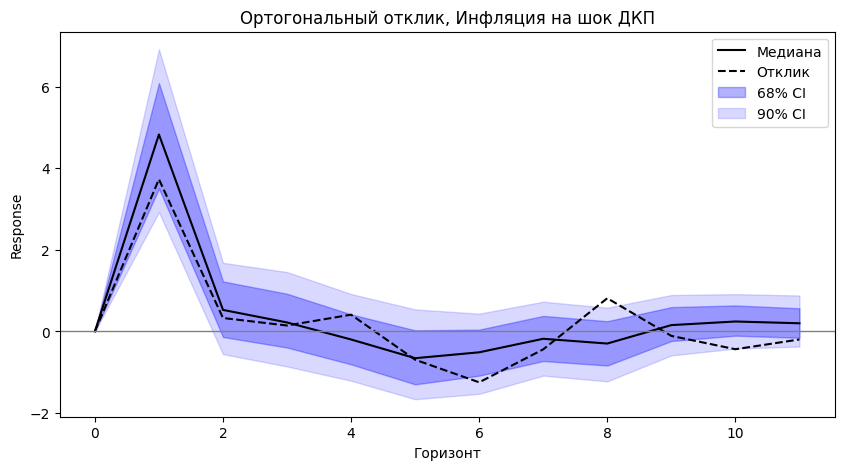

In [40]:
irf = IRF_ortho[0]
response = [1, 2]
virf = irf[:, response[0], response[1]]
for irf in IRF_ortho[1:]:
    virf = np.vstack([virf, irf[:, response[0], response[1]]])

import matplotlib.pyplot as plt


np.random.seed(0)
responses = virf

# Квантили
median = np.percentile(responses, 50, axis=0)
lower68 = np.percentile(responses, 16, axis=0)
upper68 = np.percentile(responses, 84, axis=0)

lower90 = np.percentile(responses, 5, axis=0)
upper90 = np.percentile(responses, 95, axis=0)
med_res = virf[-1, :]

# Горизонты
x_axis = np.arange(horizon)
plt.figure(figsize=(10,5))
plt.plot(x_axis, median, color='black', label='Медиана')
plt.plot(x_axis, med_res, color='black', ls = '--', label='Отклик')
plt.fill_between(x_axis, lower68, upper68, color='blue', alpha=0.3, label='68% CI')
plt.fill_between(x_axis, lower90, upper90, color='blue', alpha=0.15, label='90% CI')
plt.axhline(0, color='grey', lw=1)
plt.xlabel("Горизонт")
plt.ylabel("Response")
plt.legend()
plt.title(f"Ортогональный отклик, {y_dict[response[0]]} на {u_dict[response[1]]}")
plt.show()

In [112]:
B0 = np.linalg.inv(P)
U = B0 @ E
U = np.flip(U, axis = 1)
irf = irf_companion(B_hat_endo[:, 1:], P@ accepted_2[median_index], U.shape[1])
hd = [irf[0]*U[:, 0]]
chd = [irf[0]*U[:, 0]]
for t in range(U.shape[1]):
    contrib_t = irf[0]*U[:, t]
    
    hd.append(contrib_t)

    contrib_c = irf[0]*U[:, t]
    for h in range(1, t):  
        contrib_c += irf[h]*U[:, t-h]
    chd.append(contrib_c)

    del contrib_t, contrib_c

variable_of_interest = 1
y_hd = hd[0][variable_of_interest, :]
y_chd = chd[0][variable_of_interest, :]
for hd_t in hd[1:]:
    y_hd = np.vstack([y_hd, hd_t[variable_of_interest, :]])
for chd_t in chd[1:]:
    y_chd = np.vstack([y_chd, chd_t[variable_of_interest, :]])
y_hd = pd.DataFrame(np.flip(y_hd, axis = 0), columns = ['AS', 'AD', 'ДКП', 'АИО'], index = data.columns[:y_hd.shape[0]].to_list()[::-1])
y_chd = pd.DataFrame(np.flip(y_chd, axis = 0), columns = ['AS', 'AD', 'ДКП', 'АИО'], index = data.columns[:y_chd.shape[0]].to_list()[::-1])

In [90]:
import matplotlib.pyplot as plt

def plot_hd_stacked(df_hd, variable_name="y", shocks_labels=None):
    """
    df_hd — pd.DataFrame, где
        строки = периоды t,
        столбцы = вклады каждого шока
    variable_name — название исходной переменной
    shocks_labels — имена шоков (если None, берутся из df_hd.columns)
    """
    shocks_labels = shocks_labels or df_hd.columns

    plt.figure(figsize=(10, 6))
    plt.stackplot(df_hd.index, df_hd.T, labels=shocks_labels, alpha=0.8)
    plt.axhline(0, color="black", linewidth=0.8)
    plt.title(f"{variable_name}")
    plt.legend(loc="upper left", fontsize=9)
    plt.xlabel("Время")
    plt.ylabel("Вклад шоков")
    plt.tight_layout()
    plt.show()

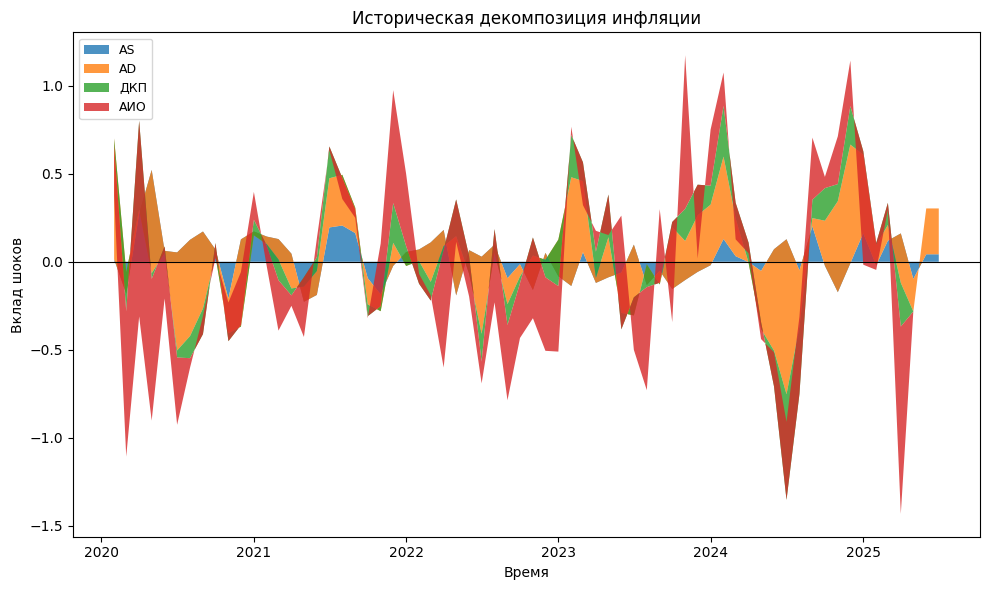

In [113]:
plot_hd_stacked(y_chd.iloc[60:, :],
                variable_name='Историческая декомпозиция инфляции')

In [82]:
data.columns[:y_hd.shape[0]].to_list()

[Timestamp('2025-07-01 00:00:00'),
 Timestamp('2025-06-01 00:00:00'),
 Timestamp('2025-05-01 00:00:00'),
 Timestamp('2025-04-01 00:00:00'),
 Timestamp('2025-03-01 00:00:00'),
 Timestamp('2025-02-01 00:00:00'),
 Timestamp('2025-01-01 00:00:00'),
 Timestamp('2024-12-01 00:00:00'),
 Timestamp('2024-11-01 00:00:00'),
 Timestamp('2024-10-01 00:00:00'),
 Timestamp('2024-09-01 00:00:00'),
 Timestamp('2024-08-01 00:00:00'),
 Timestamp('2024-07-01 00:00:00'),
 Timestamp('2024-06-01 00:00:00'),
 Timestamp('2024-05-01 00:00:00'),
 Timestamp('2024-04-01 00:00:00'),
 Timestamp('2024-03-01 00:00:00'),
 Timestamp('2024-02-01 00:00:00'),
 Timestamp('2024-01-01 00:00:00'),
 Timestamp('2023-12-01 00:00:00'),
 Timestamp('2023-11-01 00:00:00'),
 Timestamp('2023-10-01 00:00:00'),
 Timestamp('2023-09-01 00:00:00'),
 Timestamp('2023-08-01 00:00:00'),
 Timestamp('2023-07-01 00:00:00'),
 Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-05-01 00:00:00'),
 Timestamp('2023-04-01 00:00:00'),
 Timestamp('2023-03-

array([[-3.40271850e-02,  1.38258833e-01, -9.68201503e-02,
        -9.78517030e-03, -2.63806025e-02, -2.69485634e-02,
         3.50699239e-03,  5.00855329e-02,  5.81692348e-03,
        -2.24445139e-02,  1.04639724e-01,  5.76215363e-02,
         2.84874109e-02,  5.80248599e-02,  2.77116394e-02,
         4.09734468e-02, -1.00303634e-01,  6.44753939e-02,
        -2.15937143e-02,  9.36667028e-02,  5.55399115e-02,
         6.76925348e-02,  1.26837557e-01, -5.45750614e-02,
         9.09450946e-02,  3.48153058e-03,  4.89175654e-02,
        -1.17241951e-01,  9.02843913e-02, -7.84372432e-02,
         3.01244036e-02, -8.61811705e-02,  5.54990259e-03,
        -3.61826736e-02, -4.58014479e-02, -9.52991514e-02,
        -1.59617658e-02,  6.28996816e-02, -1.26766905e-01,
        -4.12229343e-02, -5.78409761e-02,  8.00050693e-03,
         2.42224817e-02,  6.29649150e-02,  3.60126928e-02,
        -3.04616423e-02, -3.08593451e-02, -2.35097959e-02,
         1.37770209e-01,  3.05447115e-02, -7.90346731e-0

In [89]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hd_stacked_bar(time_index, y_hd, shock_labels=None, title="Историческая декомпозиция во времени"):
    """
    time_index : массив или список с метками времени (T,)
    y_hd       : numpy.ndarray размером (T, K_shocks) — мгновенные вклады
    shock_labels: список имен шоков
    """
    T, K = y_hd.shape
    if shock_labels is None:
        shock_labels = [f"Шок {i+1}" for i in range(K)]

    fig, ax = plt.subplots(figsize=(12, 6))

    # начальная позиция для "стэка"
    bottom = np.zeros(T)

    # строим по каждому шоку
    for k in range(K):
        ax.bar(time_index, y_hd[:, k], bottom=bottom, label=shock_labels[k])
        bottom += y_hd[:, k]

    ax.axhline(0, color="black", lw=1)
    ax.set_title(title)
    ax.set_xlabel("Время")
    ax.set_ylabel("Вклад")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [15]:
T, K = y_hd.shape


fig, ax = plt.subplots(figsize=(12, 6))

# начальная позиция для "стэка"
bottom = np.zeros(T)

# строим по каждому шоку
for k in range(K):
    ax.bar(y_chd.index.to_list(), y_hd.iloc[:, k], bottom=bottom, label=y_chd.columns[k])
    bottom += y_hd.iloc[:, k]

ax.axhline(0, color="black", lw=1)
ax.set_title("Bcnjhbxtcrfz")
ax.set_xlabel("Время")
ax.set_ylabel("Вклад")
ax.legend(loc="best")
plt.tight_layout()
plt.show()

NameError: name 'y_hd' is not defined

In [94]:
k

0

In [92]:
y_chd.index.to_list()

[Timestamp('2015-02-01 00:00:00'),
 Timestamp('2015-03-01 00:00:00'),
 Timestamp('2015-04-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-06-01 00:00:00'),
 Timestamp('2015-07-01 00:00:00'),
 Timestamp('2015-08-01 00:00:00'),
 Timestamp('2015-09-01 00:00:00'),
 Timestamp('2015-10-01 00:00:00'),
 Timestamp('2015-11-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-04-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00'),
 Timestamp('2016-06-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00'),
 Timestamp('2016-08-01 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2016-10-01 00:00:00'),
 Timestamp('2016-11-01 00:00:00'),
 Timestamp('2016-12-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-02-01 00:00:00'),
 Timestamp('2017-03-01 00:00:00'),
 Timestamp('2017-04-01 00:00:00'),
 Timestamp('2017-05-01 00:00:00'),
 Timestamp('2017-06-

##### Стационарность AR(1) процесса

Рассмотрим простой AR(1) процесс, для слабым условием стационарности является наличие первых начальных моментов и центральных моментов
$$y_{t} = \alpha y_{t-1} + \varepsilon_{t}$$
Если записать через лаговый оператор 
$$y_{t} =  L(y_{t}) + \varepsilon_{t}$$


ВВП, инфляция, ставка руония, credX2
1, 3 -- -
2, 3 -- -
3, 3 -- +
4, 3 -- -
